# Проект: защита данных клиентов страховой компании

**Цель:**
* необходимо защитить данные клиентов страховой компании методом преобразования данных, чтобы по ним было сложно восстановить персональную информацию, но качество моделей машинного обучения при этом не ухудшилось.

## Загрузка данных

In [11]:
import sys; print(sys.version)
import pandas as pd
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 02:25:08) 
[GCC 7.5.0]


In [12]:
#загружаем данные, делаем первый взкляд на таблицу
insurance = pd.read_csv('/datasets/insurance.csv')
display(insurance)

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
...,...,...,...,...,...
4995,0,28.0,35700.0,2,0
4996,0,34.0,52400.0,1,0
4997,0,20.0,33900.0,2,0
4998,1,22.0,32700.0,3,0


In [13]:
#посмотрим, есть ли незаполненные ячейки
display(insurance.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
Пол                  5000 non-null int64
Возраст              5000 non-null float64
Зарплата             5000 non-null float64
Члены семьи          5000 non-null int64
Страховые выплаты    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


None

In [14]:
#посмотрим на статистику данных
display(insurance.describe().transpose().round(2))

,count,mean,std,min,25%,50%,75%,max
Пол,5000.0,0.50,0.50,0.0,0.0,0.0,1.0,1.0
Возраст,5000.0,30.95,8.44,18.0,24.0,30.0,37.0,65.0
Зарплата,5000.0,39916.36,9900.08,5300.0,33300.0,40200.0,46600.0,79000.0
Члены семьи,5000.0,1.19,1.09,0.0,0.0,1.0,2.0,6.0
Страховые выплаты,5000.0,0.15,0.46,0.0,0.0,0.0,0.0,5.0


In [15]:
#посмотрим, есть ли дубликаты
display(insurance.duplicated().sum())

153

* Пропусков нет.
* Типы данных уже соответствуют признакам, которые они описывают. Не будем с ними ничего делать. Тем более, что модель при предсказании всё равно работает с float.
* Присутствуют дубликаты, но мы не будем, так как после удаления дубликатов и проверки модели, ее качество практически не изменилось.

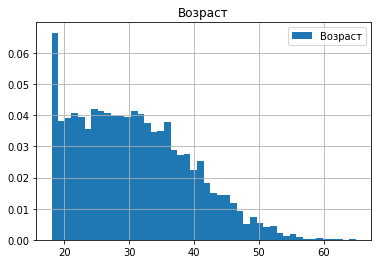

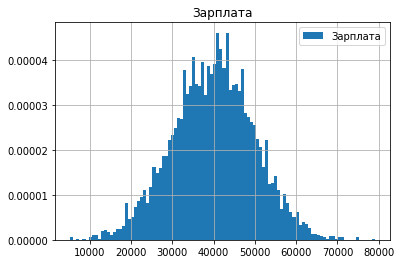

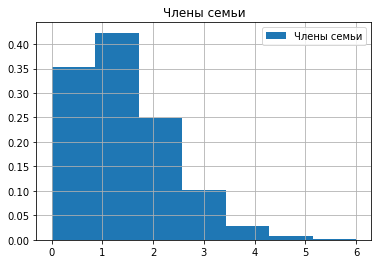

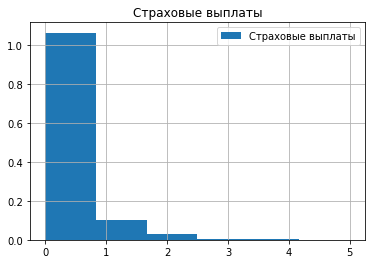

In [16]:
#посмотрим на гистограммы признаков
def histag(rows):
    for row in rows:
        plt.hist(
            insurance[row],
            bins = min(insurance[row].nunique(), 100), label = row, density=True)
        plt.grid(True)     
        plt.legend(loc='upper right')
        plt.title(row)
        plt.show()

histag(['Возраст', 'Зарплата', 'Члены семьи', 'Страховые выплаты'])

In [17]:
display(insurance['Страховые выплаты'].value_counts())

0    4436
1     423
2     115
3      18
4       7
5       1
Name: Страховые выплаты, dtype: int64

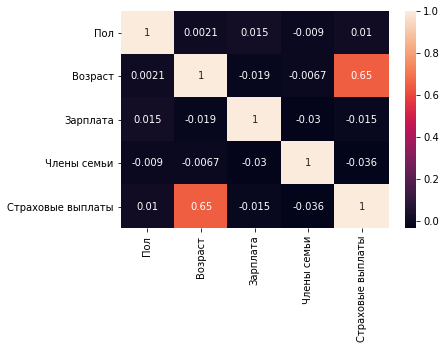

In [18]:
#посмотрим на корреляцию признаков
sns.heatmap(insurance.corr(), annot = True)

**Первый взгляд на данные сделан.**

* Отметим, что 18-тилетних клиентов анамально много.
* Отмечается практически одинаковое число женщин и мужчин, данные по заработной плате распределены нормально, выбросов нет.
* Высокую кореллицию показали признаки возраст и страховые выплаты (в основном, клиенты начинали пользоваться страховкой в возрасте старше 40)

## Теоретическое задание. Умножение матриц

**Задача:** Доказать с помощью формул, что качество линейной регрессии не изменится, если признаки умножить на обратимую матрицу.

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Ответ:** Качество линейной регрессии не изменится, если признаки умножить на обратимую матрицу.

**Обоснование:**

Будем использовать следующие свойства матриц:

$$
(A*B)^{-1} = (B)^{-1}*(A)^{-1}
$$

$$
A*A^{-1} = E
$$

$$
AE = EA = A
$$

$$
(A*B)^{T} = (B)^{T}*(A)^{T}
$$

**Задача:** сравнить ответы регрессии (a) в обоих случаях (первый - использоуются исходные признаки, второй - используются исходные признаки, умноженные на обратимую матрицу)

**Случай 1:**
$$
a = X ((X^T X)^{-1} X^T y)
$$
$$
a = X (X^{-1} (X^T)^{-1} X^T y)
$$
$$
a = X (X^{-1} ( (X^T)^{-1} X^T ) y)
$$
$$
a = X (X^{-1} E y)
$$
$$
a = X (X^{-1} y)
$$
$$
a = (X X^{-1}) y
$$
$$
a = E y
$$
$$
a = y
$$

**Случай 2:**
$$
a = XP * (((XP)^T XP)^{-1} (XP)^T y)
$$
$$
a = XP * ( (XP)^{-1} ((XP)^T)^{-1} P^T X^T y)
$$
$$
a = XP * ( (XP)^{-1} (P^T X^T)^{-1} P^T X^T y)
$$
$$
a = XP * ( (XP)^{-1} (X^T)^{-1} * ( (P^T)^{-1}  P^T ) * X^T y)
$$
$$
a = XP * ( (XP)^{-1} (X^T)^{-1} (E X^T) y)
$$
$$
a = XP * ( (XP)^{-1} * ((X^T)^{-1} X^T) * y)
$$
$$
a = XP * ( (XP)^{-1} E y)
$$
$$
a = (XP (XP)^{-1}) * y
$$
$$
a = Ey
$$
$$
a = y
$$

**Вывод:**

В обоих случаях ответы равны целевому признаку, а значит качество модели не изменится

## Алгоритм преобразования

**План действий:**  
 1) создаём рандомную матрицу;   
 2) проверяем её на обратимость (создаём единичную матрицу);  
 3) cоздаём новую матрицу данных;  
 4) Ищем метрики качества на исходных данных и на преобразованных;  
 5) делаем вывод.  

Согласно математическому доказательству пункта 2, при умножении признаков на обратимую матрицу ответы модели не изменятся.


Опираясь на доказательства пункта 2 данного проекта, зашифруем данные клинета -  создадим новую матрицу признаков, где исходные признаки будут умножены на случайно сгенерированную матрицу. Проверим сгенерированную матрицу на обратимость. Проверим качество моделей до и после умножения

## Проверка алгоритма

In [19]:
#разделим данные на признаки и целевой
features = insurance.drop(['Страховые выплаты'], axis=1)
target = insurance.loc[:, ['Страховые выплаты']]

display(features.shape)
display(target.shape)

(5000, 4)

(5000, 1)

In [20]:
#применим алгорит линейной регрессии
model = LinearRegression()
model.fit(features, target)
predictions = model.predict(features)
r2 = r2_score(target, predictions)
print('R2 = ', r2_score(target, predictions))

R2 =  0.42494550286668


По умолчанию регрессия даёт R2 == 0.42. Теперь мы знаем, от чего отталкиваться.

In [21]:
#создадим обратимую матрицу
P = np.random.normal(0, 1, size=(4,4))
P
#проверим на обратимость созданную матрицу, в случае успеха не должно быть ошибки
P_rev = np.linalg.inv(P)
P_rev
#да, обратима

array([[-0.42224197, -0.28055915, -0.26234192,  0.02916481],
       [-0.36333273, -0.67710349, -0.54565206, -1.11377108],
       [-0.29698319, -1.37168121, -0.72922164, -1.09670208],
       [-0.09073017,  0.42361314,  0.74589714,  0.74470301]])

In [22]:
#умножим признаки на обратимую матрицу, тем самым зашифруем данные клиентов
new_features = features.dot(P)
new_features

,0,1,2,3
0,-68427.777140,35793.524489,25050.803577,93105.228821
1,-52419.565255,27438.995043,19169.891475,71322.695235
2,-28968.436716,15168.385830,10588.298381,39413.265390
3,-57529.642131,30077.186850,21080.900404,78284.106124
4,-36007.139274,18842.089737,13172.477163,48988.924092
...,...,...,...,...
4995,-49249.307803,25760.031978,18032.816072,67014.301971
4996,-72291.225203,37805.401317,26478.116591,98367.439484
4997,-46767.611386,24453.871084,17133.492968,63639.222340
4998,-45111.946143,23588.320798,16524.117432,61383.805831


По таким данным, сложно рассшифровать и онять персональные данные клиентов, чего мы и добивались.

In [23]:
#обучим модель Линейной Регрессии зашифрованными признаками и сравним r2
model_new = LinearRegression()
model_new.fit(new_features, target)
predictions_new = model_new.predict(new_features)
r2_new = r2_score(target, predictions_new)
print('R2_new = ', r2_new)
print('Разница r2:', (r2_new - r2))

R2_new =  0.42494550286668253
Разница r2: 2.55351295663786e-15


Значение R2 изменилось. Сильно ли? Сравним точности как float, держа в уме, что у этого типа данных ограниченная точность.

In [24]:
def float_equal(a, b, threshold=1e-6):
    """Проверяет равеноство двух float с использованием порога."""
    return np.abs(a - b) < threshold

In [26]:
float_equal(r2_new, r2)

True

**Как мы видим, точность предсказаний не пострадала**

## Вывод

* Мы изучили возможность преобразования данных при помощи обратимой матрицы и привели математическое доказательство того, что умножение признаков на обратимую матрицу не влияет на качество линейной регрессии.
* При умножении признаков на обратимую матрицу качество (в нашем случае R2) модели не изменилось (разница r2 в первом и последнем случая стремится к нулю).
* Данные можно шифорвать не боясь за качество модели.